# Fine-tuning the model for token classification 
***
#### We will be predicting 2 depolymerase folds : Beta-helix and 6
#### Here are the results for the models :
***
esm2_t6_8M_UR50D : {'eval_loss': 0.45753657817840576, <b>'eval_accuracy': 0.8439131075453115</b>, 'eval_runtime': 40.7606, 'eval_samples_per_second': 4.293, 'eval_steps_per_second': 0.54, 'epoch': 3.0}<br>
esm2_t12_35M_UR50D : {'eval_loss': 0.35650020837783813, <b>'eval_accuracy': 0.9001007034209102</b>, 'eval_runtime': 83.4518, 'eval_samples_per_second': 2.097, 'eval_steps_per_second': 0.264, 'epoch': 3.0}<br>
esm2_t30_150M_UR50D : {'eval_loss': 0.2777683734893799, <b>'eval_accuracy': 0.9233610987968299</b>, 'eval_runtime': 219.8341, 'eval_samples_per_second': 0.796, 'eval_steps_per_second': 0.1, 'epoch': 3.0}
***

#### The model model that work also for full beta-helix is esm2_t30_150M_UR50D checkpoint-192

***
#### Next step, generate another classical ML model to predict the probability of the protein actually carrying a depolymerase :
Generate a probability/ score based on :
1. Length of the largest consecutive positive token
2. Span of the first predicted amino acid (followed by two consecutive predictions) to the last predicted one 
3. Total number of predicted amino acid
4. Fraction of the total number of predicted amino acid within the largest consecutive positive token
***

<div class="alert alert-block alert-info"> 
<b>Update 0407</b> : add a new class of dpo which fold is names "triple helix". Try applying the label "1" on it VS label "3". See what yields the best score.
</div>
Potential issues : Not enough sequences (n=30) , not the right label ("3" or "1")
***

<div class="alert alert-block alert-info"> 
Increasing the n of epoch allowed the model to converge towards optimal efficiency.<br>
3 labels worked better than 4 labels
</div>


***
<b>facebook/esm2_t12_35M_UR50D	4 labels</b>  : {'eval_loss': 0.31591448187828064, <b>'eval_accuracy': 0.9166098962781013</b>, 'eval_runtime': 63.1028, 'eval_samples_per_second': 2.314, 'eval_steps_per_second': 0.586, 'epoch': 5.0}<br>
<b>facebook/esm2_t30_150M_UR50D 4 labels</b> : {'eval_loss': 0.27637672424316406, <b>'eval_accuracy': 0.9289106801892133</b>, 'eval_runtime': 149.5283, 'eval_samples_per_second': 0.976, 'eval_steps_per_second': 0.247, 'epoch': 5.0}<br>
    
<b>facebook/esm2_t12_35M_UR50D	3 labels</b> : {'eval_loss': 0.279034823179245, <b>'eval_accuracy': 0.9167922011878604</b>, 'eval_runtime': 59.9079, 'eval_samples_per_second': 2.437, 'eval_steps_per_second': 0.618, 'epoch': 5.0}<br>
<b>facebook/esm2_t30_150M_UR50D 3 labels</b> : {'eval_loss': 0.25093308091163635, <b>'eval_accuracy': 0.9301484345765249</b>, 'eval_runtime': 175.1032, 'eval_samples_per_second': 0.834, 'eval_steps_per_second': 0.211, 'epoch': 5.0}
    
    

***
<div class="alert alert-block alert-info"> 
<b>Update 1807</b> : Based on the t-SNE results, 4 labels seem more reasonable despite the score being slightly higher for the 3 labels on the 0407. 
Added the PL_16 domains in the esm2 finetuning. Added in the CNV training proteins in Interproscan that present homology with the PL16 domain.<br>    
</div>


<b> facebook/esm2_t12_35M_UR50D 4 labels </b> : {'eval_loss': 0.34807953238487244, 'eval_accuracy': 0.9120480978760273, 'eval_runtime': 60.1534, 'eval_samples_per_second': 2.926, 'eval_steps_per_second': 0.731, 'epoch': 20.0}
<br>
<b>facebook/esm2_t30_150M_UR50D 4 labels</b> : 





<div class="alert alert-block alert-info"> 
<b>Update 1907</b> : 
Include some negative samples in the token classification task <br> Compute the MCC and compare across the different Methods
    
</div>

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/depolymerase_building/Phagedepo.Dataset.2007.tsv \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb

In [1]:
import pandas as pd
import os 
from Bio import SeqIO

path_work = "/media/concha-eloko/Linux/depolymerase_building"
#path_work = "/home/conchae/PhageDepo_pdb"

#df_depo = pd.read_csv(f"{path_work}/Dpo_domains.phagedepo.0805.final.tsv" , sep = "\t" , header = 0)
#info_PL16 = pd.read_csv(f"{path_work}/PL_16.dpo_domain.tsv", sep = "\t", header = 0)

df_depo = pd.read_csv(f"{path_work}/Phagedepo.Dataset.2007.tsv" , sep = "\t" , header = 0)


In [2]:
df_depo

,Seq_ID,Fold,Prob,Boundaries,Full_seq
0,MF417929_00038,Negative,manual,Negative,MRQNRERKLAEKAVRLAQSPDPRLRKKKMSMGFDPGSPEGDYSATV...
1,MF417929_00041,Negative,manual,Negative,MNTPQPIQFDLMNPRQHGRILFAMGMSVSEIAKQIDEKRATVESWK...
2,MH616963_00015,Negative,manual,Negative,MAKDNYPFLDYINEDKSHYKTAASAGYKDDENLFLIGESGGFLMNI...
3,MH552500_00058,Negative,manual,Negative,MVKLEANVEEVINNYPFLNYINEDKSQYKTATNAGYDDPDNLFLIG...
4,BK010471_00079,Negative,manual,Negative,MADGKYPFLEYIEEPDKEKKYKKASDCGWYDPHNNFLIGDSGGFLL...
...,...,...,...,...,...
2290,phagedepo__4646,right-handed beta-helix,1.0,4646_A_5_379_783,MSVGLYGDGVSESQENINVTQYGWTNEDVAGITLIQDYLNQIQTLF...
2291,phagedepo__6447,right-handed beta-helix,1.0,6447_A_5_337_699,MGYFQMTRNVEELFGGVITAPHQIPFTYKSNVGGETFLSLPFYPVT...
2292,phagedepo__1994,right-handed beta-helix,1.0,1994_A_5_283_679,MSDCKSYVSKEDLQALKESQQHIEHVARSRNAAGEKALQVTDAIRG...
2293,phagedepo__4581,right-handed beta-helix,0.872,full_protein,MLQVKDFSGATHAEQIQNAINAASTSALHKTVQLEENKDYSITAPI...


> Create the Dpo_domains.phagedepo.0407.final.tsv file 

In [8]:
from Bio import SeqIO

info_PL16_1607 = pd.read_csv(f"{path_work}/PL_16.proteins.boundaries.tsv", sep = "\t", header = 0)
fasta_PL16 = SeqIO.parse(f"{path_work}/PL16.index.multi.fasta" , "fasta")
info_PL16 = pd.read_csv(f"{path_work}/PL_16.dpo_domain.tsv", sep = "\t", header = 0)


sequences = set()

with open(f"{path_work}/Dpo_domains.phagedepo.1607.final.tsv", "w") as outfile :
    outfile.write("Seq_ID\tFold\tProb\tBoundaries\tFull_seq\n")
    for _,row in info_PL16_1607.iterrows() :
        Seq_ID = row["protein_fasta"] 
        Fold = "triple-helix"
        Prob = "manual"
        Boundaries = row["boundaries"] 
        for record in fasta_PL16 :
            if record.description == Seq_ID :
                Full_seq = record.seq
                sequences.add(Full_seq)
                break
        outfile.write(f"{Seq_ID}\t{Fold}\t{Prob}\t{Boundaries}\t{Full_seq}\n")

with open(f"{path_work}/Dpo_domains.phagedepo.1607.final.tsv", "a+") as outfile :
    for _,row in info_PL16.iterrows() :
        Seq_ID = row["protein_fasta"].split(".fa")[0]
        Fold = "triple-helix"
        Prob = "manual"
        Boundaries = row["boundaries"] 
        prot_parse = SeqIO.parse(f"{path_work}/0407_dpos/{row['protein_fasta']}" , "fasta")
        for record in prot_parse :
            Full_seq = record.seq
            break
        if Full_seq not in sequences :
            sequences.add(Full_seq)
            outfile.write(f"{Seq_ID}\t{Fold}\t{Prob}\t{Boundaries}\t{Full_seq}\n")
        

with open(f"{path_work}/Dpo_domains.phagedepo.1607.final.tsv", "a+") as outfile :
    for _,row in df_depo.iterrows() :
        outfile.write(f"{row['Seq_ID']}\t{row['Fold']}\t{row['Prob']}\t{row['Boundaries']}\t{row['Full_seq']}\n")
        
        

In [16]:
from Bio import SeqIO

with open(f"{path_work}/Dpo_domains.phagedepo.0407.final.tsv", "w") as outfile :
    outfile.write("Seq_ID\tFold\tProb\tBoundaries\tFull_seq\n")
    for _,row in info_PL16.iterrows() :
        Seq_ID = row["protein_fasta"].split(".fa")[0]
        Fold = "triple-helix"
        Prob = "manual"
        Boundaries = row["boundaries"] 
        prot_parse = SeqIO.parse(f"{path_work}/0407_dpos/{row['protein_fasta']}" , "fasta")
        for record in prot_parse :
            Full_seq = record.seq
            break
        outfile.write(f"{Seq_ID}\t{Fold}\t{Prob}\t{Boundaries}\t{Full_seq}\n")
        
with open(f"{path_work}/Dpo_domains.phagedepo.0407.final.tsv", "a+") as outfile :
    for _,row in df_depo.iterrows() :
        outfile.write(f"{row['Seq_ID']}\t{row['Fold']}\t{row['Prob']}\t{row['Boundaries']}\t{row['Full_seq']}\n")
        
        


In [11]:
df_beta_helix = df_depo[df_depo["Fold"] == "right-handed beta-helix"]
df_beta_prope = df_depo[df_depo["Fold"] == "6-bladed beta-propeller"]
df_beta_triple =  df_depo[df_depo["Fold"] == "triple-helix"]

In [20]:
df_beta_triple

,Seq_ID,Fold,Prob,Boundaries,Full_seq
0,rcsb_pdb_2YW0,triple-helix,manual,104:308,MSENIPLRVQFKRMKAAEWARSDVILLESEIGFETDTGFARAGDGH...
1,MGYP001296033211,triple-helix,manual,37:260,GNTLYYTSDGLQAGTTIYTDGSVIGVGTTLPKAKLHLMSNSVDRTS...
2,MGYP001613371361,triple-helix,manual,full,ASSSTSVGGAILLENTGNTGAGFIIYSNAGASSGRLMNIRADNIAF...
3,MGYP001566598439,triple-helix,manual,full,DPTITFNSGAVAVGGALSANNLISTTIANTVNSQGLTVTQNDTTNN...
4,MGYP001559216884,triple-helix,manual,full,AIGSLVPTELLSLTGNFSITNPNAGKTFIIDPNGAAPTSTSTGGAI...
5,rcsb_pdb_2YX2,triple-helix,manual,104:297,MSENIPLRVQFKRMKAAEWARSDVILLESEIGFETDTGFARAGDGH...
6,MGYP001585967839,triple-helix,manual,full,DGTGAGLGITSTSDAALSLSNSGNGNHTAIINYTGTGSAQAALNIT...
7,MGYP000559111392,triple-helix,manual,full,MYIDQNANTSASTSVGGAVLLDNSGNAGAGLVVYSTQGASGTGHLI...
8,MGYP000616189667,triple-helix,manual,full,RDLVKITNDDAAAVAATALSIQSDGGRGIFIDSNLAAGLPSLEIDS...
9,MGYP000201891019,triple-helix,manual,full,EQYGMGRAGHFEIVNASNNTDALHAATNGNGAAIRGFSTGNGTAGE...


> Create the negative dataset :

In [ ]:
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/databases/Millard_jan_2023/5Jan2023_vConTACT2_proteins.faa \
/media/concha-eloko/Linux/Databases


In [3]:
from Bio import SeqIO

#path_mill_db = "/home/conchae/databases/Millard_jan_2023/5Jan2023_vConTACT2_proteins.faa"
path_mill_db = "/media/concha-eloko/Linux/Databases/5Jan2023_vConTACT2_proteins.faa"

proteins_annot = {record.id : " ".join(record.description.split(" ")[1:]) for record in SeqIO.parse(path_mill_db, "fasta")}
proteins_seq = {record.id : record.seq for record in SeqIO.parse(path_mill_db, "fasta")}


In [4]:
# Make a relevant file for the negative sequences : 
path_work = "/media/concha-eloko/Linux/depolymerase_building"

negative_annotation = {"terminase" : [], "helicase" : [], "DNA polymerase" : [], "RNaseH" : [],
                       "methyltransferase" : [] , "endolysin" : [], "major head protein" : [], "major tail" :[],
                      "lysozyme" : [] , "cytidylyltransferase" : [], "exonuclease" : [], "endonuclease" : [], 
                      "exopolyphosphatase" : [] , "ribosyltransferase" : [], "minor tail" : []}

with open(f"{path_work}/negative_sequences.multi.test.tsv","w") as outfile :
    track_sequences = set()
    for prot_id,description in proteins_annot.items() :
        for neg_annot in negative_annotation :
            if description.lower().count(neg_annot.lower()) > 0 :
                if len(negative_annotation[neg_annot]) < 100 and len(str(proteins_seq[prot_id])) > 200 and str(proteins_seq[prot_id]) not in track_sequences:
                    track_sequences.add(str(proteins_seq[prot_id]))
                    a = (prot_id , str(proteins_seq[prot_id]))
                    negative_annotation[neg_annot].append(a)
                    break
                else :
                    break
    for neg_annot in negative_annotation :
        for _,tup_neg in enumerate(negative_annotation[neg_annot]) :
            outfile.write(f"{neg_annot}\t{tup_neg[0]}\t{tup_neg[1]}\n")

> Create the 1907 dataframe 

In [5]:
import pandas as pd 

df_depo = pd.read_csv(f"{path_work}/Dpo_domains.phagedepo.1607.final.tsv" , sep = "\t" , header = 0)
df_neg = pd.read_csv(f"{path_work}/negative_sequences.multi.test.tsv", sep = "\t", names = ["annotation", "prot_id","sequence"])


In [6]:
with open(f"{path_work}/Phagedepo.Dataset.2007.tsv", "w") as outfile :
    outfile.write(f"Seq_ID\tFold\tProb\tBoundaries\tFull_seq\n")
    for _,row in df_neg.iterrows() :
        Seq_ID = row["prot_id"] 
        Fold = "Negative"
        Prob = "manual"
        Boundaries = "Negative"
        Full_seq = row["sequence"]
        outfile.write(f"{Seq_ID}\t{Fold}\t{Prob}\t{Boundaries}\t{Full_seq}\n")
    for _,row in df_depo.iterrows() :
        Seq_ID = row["Seq_ID"] 
        Fold = row["Fold"] 
        Prob = row["Prob"] 
        Boundaries = row["Boundaries"] 
        Full_seq = row["Full_seq"] 
        outfile.write(f"{Seq_ID}\t{Fold}\t{Prob}\t{Boundaries}\t{Full_seq}\n")


***
> Prepare the labels 

In [16]:
def get_labels(df , label = 1) :
    labels_df = []
    for _,row in df.iterrows():
        info = row["Boundaries"]
        seq_length = len(row["Full_seq"])
        if info == "Negative" :
            labels = [label] * seq_length
            labels_df.append(labels)
        elif info == "full_protein" or info == "full" :
            labels = [label] * seq_length
            labels_df.append(labels)
        elif info.count(":") > 0 : 
            start = int(info.split(":")[0])
            end = int(info.split(":")[1])
            labels = [0 if i < start or i >= end else label for i in range(seq_length)]
            labels_df.append(labels)
        else :
            start = int(info.split("_")[-2])
            end = int(info.split("_")[-1])
            labels = [0 if i < start or i >= end else label for i in range(seq_length)]
            labels_df.append(labels)
    return labels_df


In [14]:
df_beta_helix = df_depo[df_depo["Fold"] == "right-handed beta-helix"]
df_beta_prope = df_depo[df_depo["Fold"] == "6-bladed beta-propeller"]
df_beta_triple =  df_depo[df_depo["Fold"] == "triple-helix"]
df_negative = df_depo[df_depo["Fold"] == "Negative"]

In [19]:
# Beta-helix :
labels_beta_helix = get_labels(df_beta_helix , label = 1)
seq_beta_helix = df_beta_helix["Full_seq"].to_list()

# Beta propeller : 
labels_beta_propeller = get_labels(df_beta_prope , label = 2)
seq_beta_propeller = df_beta_prope["Full_seq"].to_list()

# Triple helix : 
labels_triple_helix = get_labels(df_beta_triple , label = 1)
seq_triple_helix = df_beta_triple["Full_seq"].to_list()

# Negative :
labels_negative = get_labels(df_negative , label = 0)
seq_negative = df_negative["Full_seq"].to_list()

# The input data :
sequences = seq_beta_helix + seq_beta_propeller + seq_triple_helix + seq_negative
labels = labels_beta_helix + labels_beta_propeller + labels_triple_helix + labels_negative

***
# II. Fine-tuning ESM2

In [20]:
from sklearn.model_selection import train_test_split

train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.2, random_state = 243)
train_esm2 , train_CNV , esm2_labels , CNV_labels = train_test_split(train_sequences, train_labels, test_size=0.25, random_state = 243)


In [59]:
train_CNV_df = pd.DataFrame(train_CNV, columns = ["sequence"])
train_CNV_df["Label"] = 1
train_CNV_df

,sequence,Label
0,MSNIVAQPFPYFPDPDRGRALFNADIYIGLIDLDPFVPTNRIDVFY...,1
1,MAAFEGSMKSQLQGVSQQIARERLDGQVTAQDNMLSDVVTGLRRRP...,1
2,MTVSAQNRKNIFTTNGVTVYFPFTFSVNTADQVMALTRDSDGVETE...,1
3,MTSRRLFLGAFTAGAVTVAAGASEAAAAEAEGVVEGDTTFTGAVKA...,1
4,MSLVQLIDSTVGLRNELTQPDGAYLTGLGASTVGALLDTTRKLSYY...,1
...,...,...
141,MISQFNQPRGSTSIEVNKQSIARNFGVKEDEVVYFTVGIDLSGFKV...,1
142,MTTKVNNRMIDGATVNVLDFGADPSGQTDSTSQIQEAINTAKTQGV...,1
143,MTNPTLITTPFAENGDKNTIPESVGANPQNATMQAGFPPITQQKIS...,1
144,MAADGTVTGTGTKWQSSLSLIRPGATIMFLSSPIQMAVVNKVVSDT...,1


In [8]:
from transformers import AutoTokenizer

# Define the model :
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
model_checkpoint = "facebook/esm2_t30_150M_UR50D"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_tokenized = tokenizer(train_esm2)
test_tokenized = tokenizer(test_sequences)

/home/concha-eloko/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
from datasets import Dataset

train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset = train_dataset.add_column("labels", esm2_labels)
test_dataset = test_dataset.add_column("labels", test_labels)

In [11]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

num_labels = 3
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForTokenClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.weight', 'cla

In [12]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [13]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 4

args = TrainingArguments(
    f"{model_name}-finetuned-depolymerase.0407.3_labels",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.001,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    push_to_hub=False,
)

In [14]:
from evaluate import load
import numpy as np

metric = load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    return metric.compute(predictions=predictions, references=labels)

In [15]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

trainer.train()

/home/concha-eloko/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 523
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 786


RuntimeError: CUDA out of memory. Tried to allocate 130.00 MiB (GPU 0; 1.96 GiB total capacity; 1.24 GiB already allocated; 66.38 MiB free; 1.36 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
#!/bin/bash
#BATCH --job-name=FT_model
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=50gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=FT_model%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/fine_tune.esm2.py

***
# III. Testing the model :

In [ ]:
# import the model :
rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t30_150M_UR50D-finetuned-depolymerase \
/media/concha-eloko/Linux/depolymerase_building/ 

rsync -avzhe ssh \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb/script_files/esm2_t12_35M_UR50D-finetuned-depolymerase.0407.3_labels \
/media/concha-eloko/Linux/depolymerase_building/ 

In [31]:
import pandas as pd
import os 
from collections import Counter
import torch
path_work = "/media/concha-eloko/Linux/depolymerase_building"
#path_work = "/home/conchae/PhageDepo_pdb"



In [29]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

model_path = f"{path_work}/esm2_t12_35M_UR50D-finetuned-depolymerase.0407.3_labels/checkpoint-550/"
#model_path = "/home/conchae/PhageDepo_pdb/script_files/esm2_t30_150M_UR50D-finetuned-depolymerase/checkpoint-198"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

model.eval()

Some weights of the model checkpoint at /media/concha-eloko/Linux/depolymerase_building/esm2_t12_35M_UR50D-finetuned-depolymerase.0407.3_labels/checkpoint-550/ were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EsmForTokenClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0): EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((480,), eps=1e-05, elementw

In [46]:
# Encode input text
input_text = "MTVKISGILKDALARPLANVAIRFLSLKTSSNIVIGVDTDFRTANDGSYDIDVVSGTYGVLMNFGSYEKIGEINVYNDSLPGTLEDFLTIPGIEEITPEILAQVIQARNNAVNAANNAASDATTIINEQLQNQKNEFDQFLLSSGYVFLGDYEDGPFQFSVRNQYIRYSNQYYRLDAATDVGFTTTGTDATSFASDVTHFVLMDGDTLRQNLGSSDGTSWVAKLGNKPLVAISYYKNQGLSDQDAVQAAFNESSNILIDHDIALTDYITFDRSEECYVYRKPGVTITGHGYLPKLRTNPAHVVETAIRHSKTSDRGGSYDRTYSHQSLAAEMVVHDVLSTDPGQENFVALYSGIESFNCQKQRMWAFNTVTSAHNLKTGDEIYGCEIDMNVDGTLDGGGQFVGVYIAGIGDVRTCANADGIRVQRLRDGVYKWQYGLRIFDSMTGINITDASTYSIFASGSAPIVRRKTTQDGGWSYTHSLSASSVKWGVDDYGDTYSRRLYLGTGDGKSKNRVNLDGGVSYYTTNAAVAWGSIAANAYVDKDITTLVGVSIADWTNYTIDVTPIGYAGAMPVVAVQAYINSTKTQAYVRIINISGAPLSSCNVGLNIKVSGHSATN"  # Replace this with your input text
input_ids = tokenizer.encode(input_text, return_tensors='pt', truncation= True)

# Get token classifications
with torch.no_grad() :
    outputs = model(input_ids)

# The model returns logits which can be turned into probabilities using softmax
import torch
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

# the order of labels in model.config.id2label should match the order of probabilities in probs
labels = model.config.id2label

tokens = []
for token_id, token_probs in zip(input_ids[0], probs[0]):
    top_label_id = token_probs.argmax().item()
    tokens.append(int(labels[top_label_id].split("_")[1]))
    #print(f"{tokenizer.decode([token_id])}: {labels[top_label_id]}")
    
"""with open(f"{path_work}/output.token.txt", "w") as outfile :
    outfile.write(str(tokens))"""
dict(Counter(tokens))




{0: 370, 1: 249}

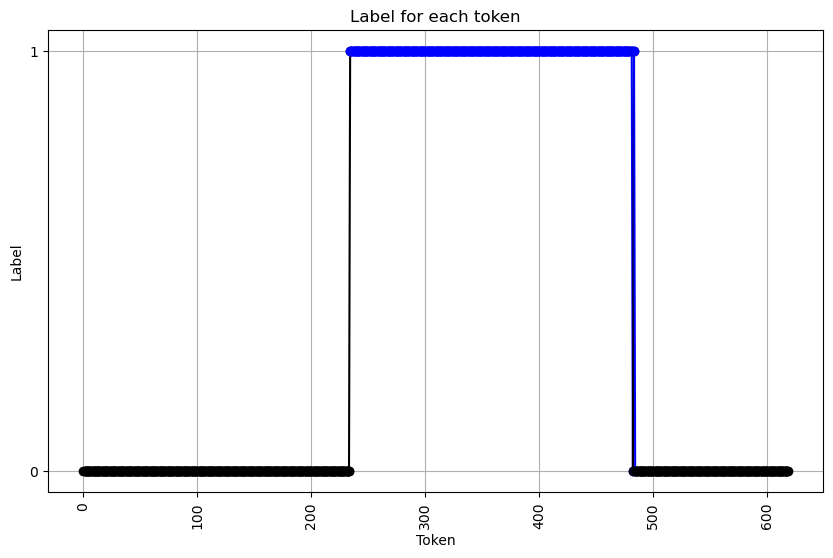

In [47]:
import matplotlib.pyplot as plt
import numpy as np

tokens = np.array(tokens)  # convert your list to numpy array for convenience

# create your plot
plt.figure(figsize=(10,6))

# plot data
for i in range(len(tokens) - 1):
    if tokens[i] == 0:
        color = 'black'
    elif tokens[i] == 1:
        color = 'blue'
    else:
        color = 'red'
        #tokens[i] == 1
    plt.plot([i, i+1], [tokens[i], tokens[i+1]], color=color, marker='o')

plt.xlabel('Token')
plt.ylabel('Label')
plt.title('Label for each token')
plt.xticks(rotation='vertical')
plt.yticks(np.arange(2), ['0', '1'])  
plt.grid(True)
plt.show()

***
# Test on Bea's phages :

In [ ]:
import os 
import pandas
import torch
from Bio import SeqIO
from collections import Counter
from transformers import AutoModelForTokenClassification, AutoTokenizer

path_work = "/home/conchae/PhageDepo_pdb"
path_fasta = f"{path_work}/Bea_phages_no_Dpo"
path_bea_out = f"{path_fasta}/model_outputs"
model_path = f"{path_work}/script_files/esm2_t12_35M_UR50D-finetuned-depolymerase/checkpoint-198/"


tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)


def make_prediction(fasta_txt) :
    if len(fasta_txt) > 200 :
        input_ids = tokenizer.encode(input_text, return_tensors='pt')
        outputs = model(input_ids)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        labels = model.config.id2label
        tokens = []
        for token_id, token_probs in zip(input_ids[0], probs[0]):
            top_label_id = token_probs.argmax().item()
            tokens.append(labels[top_label_id].split("_")[1])
        return tokens
        
for multifasta in os.listdir(path_fasta) :
    if multifasta[-5:] == "fasta" :
        fastas = SeqIO.parse(f"{path_fasta}/{multifasta}" , "fasta")
        for record in fastas :
            locus_tag = record.description.split("locus_tag=")[1].split("]")[0]
            annotation = "_".join(record.description.split("protein=")[1].split("]")[0].split())
            sequence = record.seq
            results = make_prediction(sequence)
            if "1" in dict(Counter(tokens)) :
                n_depo = dict(Counter(tokens))["1"]
            elif "2" in dict(Counter(tokens)) :
                n_depo = dict(Counter(tokens))["1"]
            else : 
                n_depo = 0
            with open(f"{path_bea_out}/{locus_tag}.{annotation}__{n_depo}.out" , "w") as outfile :
                outfile.write(str(results))
            
# ************************************************************* 
#!/bin/bash
#BATCH --job-name=bea_pred
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=100gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=bea_pred%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/beas_phages.py

***
# Bea's data insights : 
#### Add more sequences for 6 bladed-beta propeller ==> That was the missing fold in Bea's searching.
#### Need to add negative data.
#### The annotations : terminase large subunit , helicase , DNA , polymerase , RNaseH , methyltransferase

***
# Try to improve further the performance of the model using bayesian search :

In [ ]:
import optuna
from optuna.trial import TrialState
from transformers import IntervalStrategy, AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import TrainerCallback, TrainerState, TrainerControl
from datasets import Dataset
from evaluate import load
import logging
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
path_work = "/home/conchae/PhageDepo_pdb"

# ******************************************************************
# LOAD THE DATA :
df_depo = pd.read_csv(f"{path_work}/Dpo_domains.phagedepo.0805.final.tsv" , sep = "\t" , header = 0)

df_beta_helix = df_depo[df_depo["Fold"] == "right-handed beta-helix"]
df_beta_prope = df_depo[df_depo["Fold"] == "6-bladed beta-propeller"]

def get_labels(df , label = 1) :
    labels_df = []
    for _,row in df.iterrows():
        info = row["Boundaries"]
        seq_length = len(row["Full_seq"])
        if info == "full_protein" :
            labels = [label] * seq_length
            labels_df.append(labels)
        else :
            start = int(info.split("_")[-2])
            end = int(info.split("_")[-1])
            labels = [0 if i < start or i >= end else label for i in range(seq_length)]
            labels_df.append(labels)
    return labels_df

# Beta-helix :
labels_beta_helix = get_labels(df_beta_helix , label = 1)
seq_beta_helix = df_beta_helix["Full_seq"].to_list()

# Beta propeller :
labels_beta_propeller = get_labels(df_beta_prope , label = 2)
seq_beta_propeller = df_beta_prope["Full_seq"].to_list()

# The input data :
sequences = seq_beta_helix + seq_beta_propeller
labels = labels_beta_helix + labels_beta_propeller


# ******************************************************************
# DEFINING THE MODEL SIZE : 
#model_checkpoint = "facebook/esm2_t6_8M_UR50D"
#model_checkpoint = "facebook/esm2_t12_35M_UR50D"
model_checkpoint = "facebook/esm2_t30_150M_UR50D"


# ******************************************************************
# PREPROCESS THE DATA FOR THE MODEL :
train_sequences, test_sequences, train_labels, test_labels = train_test_split(sequences, labels, test_size=0.25, shuffle=True)

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
train_tokenized = tokenizer(train_sequences)
test_tokenized = tokenizer(test_sequences)

train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

train_dataset = train_dataset.add_column("labels", train_labels)
test_dataset = test_dataset.add_column("labels", test_labels)

num_labels=3
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

from evaluate import load

metric = load("accuracy")
# ******************************************************************
# THE SEARCH : 

logging.basicConfig(filename=f'{path_work}/hyperparameters_tuning.log', level=logging.INFO)

class ObjectiveWrapper:
    def __init__(self, objective):
        self.objective = objective

    def __call__(self, trial):
        result = self.objective(trial)
        # Log the result of each trial
        logging.info(f'Trial {trial.number} finished with value: {result} and parameters: {trial.params}.')
        return result


class MyCallback(TrainerCallback):
    def __init__(self, trial: optuna.trial.Trial):
        self._trial = trial

    def on_evaluate(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, metrics=None, **kwargs):
        if state.is_local_process_zero:
            self._trial.report(metrics["eval_loss"], step=state.global_step)
            if self._trial.should_prune():
                raise optuna.exceptions.TrialPruned()


def objective(trial):
    model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
    batch_size = trial.suggest_int("batch_size", 8, 16)
    learning_rate = trial.suggest_float("lr", 1e-6, 1e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    args = TrainingArguments(
        f"{model_name}-finetuned-depolymerase",
        evaluation_strategy = "epoch",
        save_strategy = "epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=3,
        weight_decay=weight_decay,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='./logs',
        push_to_hub=False,
    )
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator,
        callbacks=[MyCallback(trial)]
    )
    trainer.train()
    return trainer.evaluate()["eval_accuracy"]



#def compute_metrics(eval_pred):
#    predictions, labels = eval_pred
#    labels = labels.reshape((-1,))
#    predictions = np.argmax(predictions, axis=2)
#    predictions = predictions.reshape((-1,))
#    predictions = predictions[labels!=-100]
#    labels = labels[labels!=-100]
#    return metric.compute(predictions=predictions, references=labels)



def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    labels = labels.reshape((-1,))
    predictions = np.argmax(predictions, axis=2)
    predictions = predictions.reshape((-1,))
    predictions = predictions[labels!=-100]
    labels = labels[labels!=-100]
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}


wrapper = ObjectiveWrapper(objective)

pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,
    n_warmup_steps=30
)

study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(wrapper, n_trials=10, n_jobs=40)

# Log the result of the optimization
best_trial = study.best_trial
logging.info(f'Best trial finished with value: {best_trial.value} and parameters: {best_trial.params}.')


In [ ]:
#!/bin/bash
#BATCH --job-name=BAYES_search__
#SBATCH --qos=long-mem 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=40
#SBATCH --mem=300gb 
#SBATCH --time=2-00:00:00 
#SBATCH --output=BAYES_search__%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/bayesian_search.py